# Introduction & Preparation 

## Introduction

The goal of this notebook is to showcase the so-called 'Inverse Optimization' algorithm on some synthetic datasets. The goal of this algorithm is to generate some new dataset that has the same (persistent) topological characteristics as some target dataset that we input. For this we use the persistent diagrams of some input and target dataset as a loss.

## Preparation

In this notebook we make use of different packages. One of the packages that we make use of is `inverse_optim` which include functions tailor made for this notebook. We want to make sure that any changes in `inverse_optim` are directly reflected in this notebook. For this we use the first three lines of code, after which we include the packages as usual. If you run into problems with `inverse_optim`, please read the README.md file on the repository.

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import pd
from inverse_optim import sancho
import tadasets
import gudhi as gd
import powerbox as pbox

Modules to reload:
all-except-skipped

Modules to skip:



# Circle and the Figure Eight

First, choose which figure you would like to generate. You can comment out the figure you are not interested in.

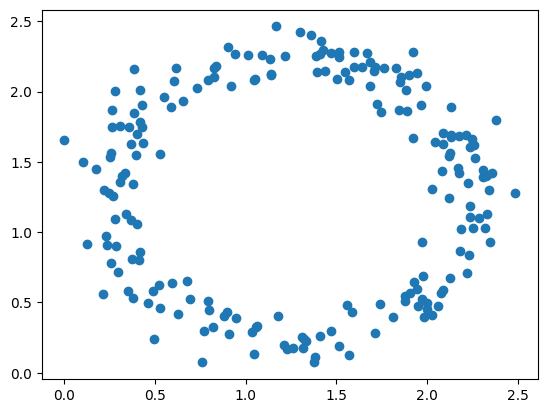

In [14]:
# This is a synthetic data set that we want "approximate"
N = 200
goal_pts = tadasets.dsphere(n=N, d=1, noise=0.1) # circle
# goal_pts = tadasets.infty_sign(n=N, noise=0.1) # figure eight

# Translate whole point set so that nothing is negative
min_coord = np.min(goal_pts)
goal_pts = goal_pts - min_coord

# Find box_size
box_size = np.max(goal_pts)

# To perform Stochastic Gradient Descent (SGD), we need our point set to be of tensor type
goal_pts = torch.tensor(goal_pts)

# Plot the initial/goal data set
P = goal_pts.detach().numpy()
plt.scatter(P[:, 0], P[:, 1])
plt.show()

Below you will find multiple methods with which you can use the algorithm. The current methods include: Ripser filtration, Alpha-DTM (Hybrid) Filtration and Alpha-Ripser Hybrid Filtration.

## Ripser Filtration

### Creation of dataset

For optimization purposes, we are interested in the pairwise distances of all the points. 

In the Rips filtration, we are constantly looking at sub-complexes of the largest possible complex given a dataset. The interesting parts of the filtration (that capture the persistent features) happen at a stage that is in the beginning before the total complex is reached. So if we are interested in optimizing the filtration, we could put a threshold on the possible edge lengths that are drawn without losing (too much) information.

To that end we will look at the pairwise distances of all points in the initial/goal point cloud and then determine what the 60-90th percentile is. It could be argued that for higher dimensional PD's, the persistence happens at later stages in general, meaning you would need a higher percentile. 

A guideline that is currently used (based on clinical estimations of a few trials and input of other postdocs/phds who are working with this project):
- Zero dimensional PD: 70
- One dimensional PD: 80
- Two dimensional PD: 90



In [15]:
from scipy.spatial.distance import cdist

# Initialize percentile
percentile = 60

# Creation of list of all pairwise distances
goal_D = cdist(goal_pts, goal_pts)
distance_vec = goal_D.flatten()

# Define maximum edge length
max_edge_length = np.percentile(distance_vec, percentile)

In [16]:
# Creation of the PD that we want to get to
goal_pd = pd.create_rips_pd(pts=goal_pts, max_edge_length=max_edge_length)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric. Warning: This is extremely slow compared to the other filtrations.

In [21]:
lr_list = np.linspace(0.001, 1, 6)
dim = 2
epochs = 300
decay_speed = 30 # Higher numbers correspond to slower speeds
sliced = True
filtr = "rips"
parallel = True
loss_lists = research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=dim, epochs=epochs, \
                          decay_speed=decay_speed, sliced=sliced, filtr=filtr, max_edge_length=max_edge_length,\
                              box_size=box_size, parallel=parallel)

100%|██████████| 300/300 [01:41<00:00,  2.95it/s]


Let us make a plot and see what came out of this.

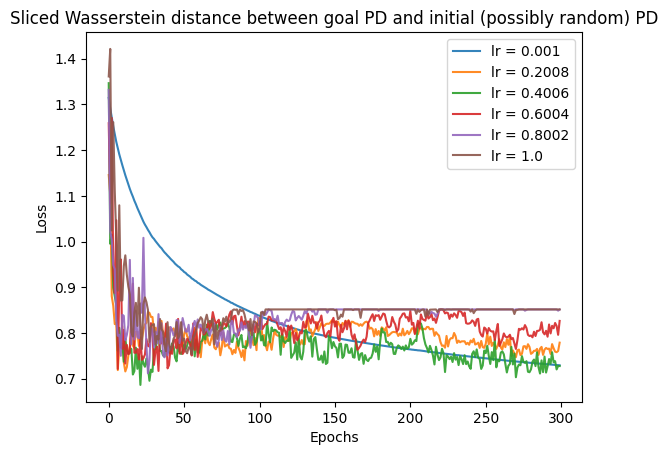

In [23]:
# Plotting all the losses
for loss_list, lr in zip(loss_lists, lr_list):
    plt.plot(range(epochs), loss_list, label=f"lr = {lr}", alpha=0.9)

# Loss plot
if sliced==False:
    plt.title("Wasserstein distance between goal PD and initial (possibly random) PD")
elif isinstance(sliced, float):
    plt.title(f"Top-k=({sliced}) distance between goal PD and initial (possibly random) PD")
elif sliced==True:
    plt.title("Sliced Wasserstein distance between goal PD and initial (possibly random) PD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

After running the above code, plug in the best learning rate:

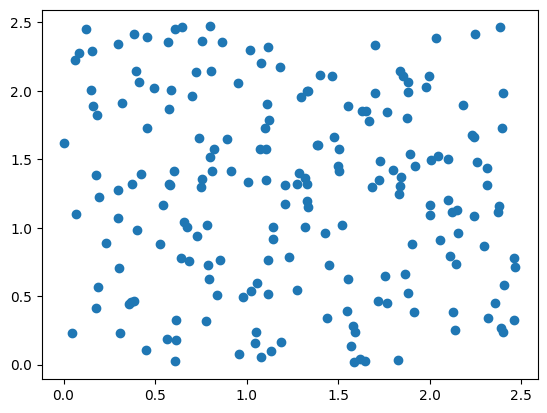

 16%|█▌        | 96/600 [00:01<00:07, 68.96it/s]

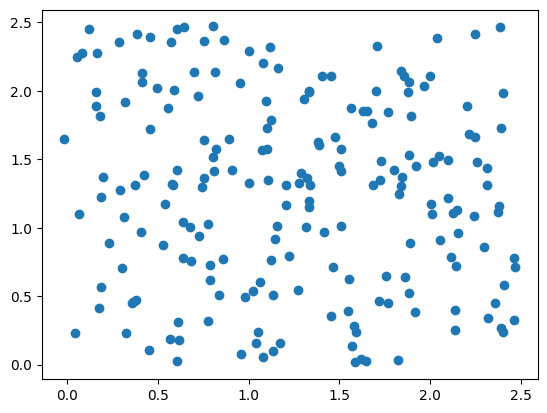

 32%|███▎      | 195/600 [00:02<00:04, 91.74it/s]

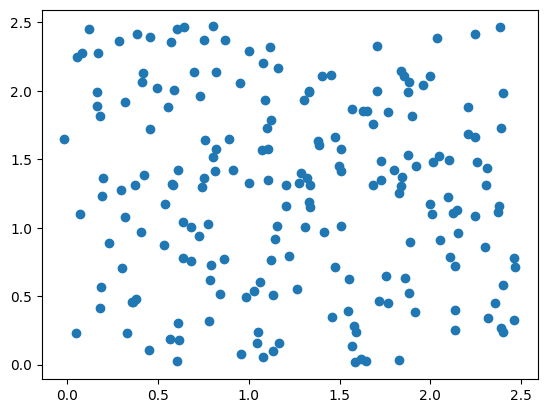

 50%|████▉     | 299/600 [00:03<00:03, 91.62it/s]

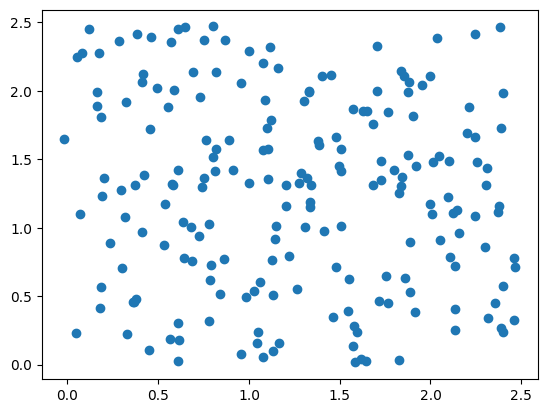

 66%|██████▋   | 398/600 [00:05<00:02, 83.38it/s]

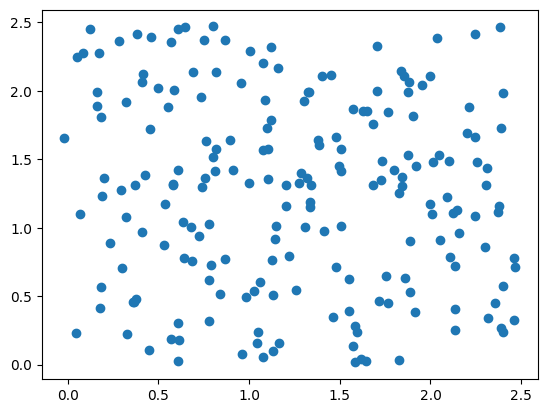

 83%|████████▎ | 497/600 [00:06<00:01, 84.16it/s]

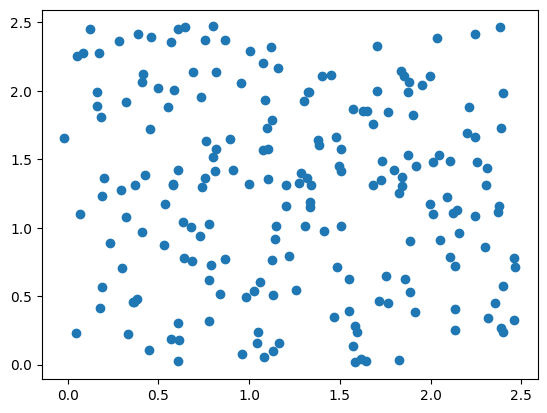

100%|█████████▉| 598/600 [00:07<00:00, 89.51it/s]

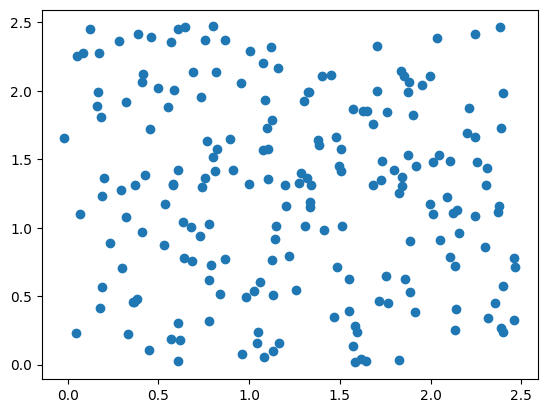

100%|██████████| 600/600 [00:08<00:00, 74.53it/s]


In [36]:
# Generation of new dataset
epochs = 600

final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.001, epochs=600, \
                                   decay_speed=decay_speed, investigate=False, sliced=True, \
                                    filtr=filtr, box_size=box_size)

### The powerspectrum

Later on we will focus on so-called Gaussian Random Fields (GRF). A characteristic feature of GRF's is their power spectrum. For that reason, we will already test whether the generated data set and the target dataset have the same power spectrum.

In [37]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [38]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

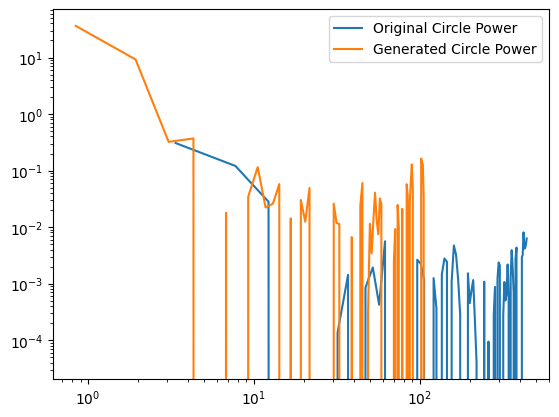

In [39]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Alpha DTM Filtration

### Creation of dataset

In [64]:
# Creation of the PD that we want to get to
goal_pd = pd.create_hybrid_dtm_pd(goal_pts)

# plt.scatter(goal_pd[0][:,0], goal_pd[0][:,1])
# plt.scatter(goal_pd[1][:,0], goal_pd[1][:,1])

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

Note: It seems like setting `m=0.7` and `p=1.5` give a circle without any stray points inside the circle. If you would like to change these values, they are unfortunately still hardcoded in the `gen_data.py` file. Go to the function `create_hybrid_dtm_pd` and change the values there. Support for changing these values in this notebook will come soon.

In [67]:
lr_list = np.linspace(0.1, 1, 6)

dim = 2
decay_speed = 30
sliced = False
epochs = 300
filtr = "alpha_dtm"
parallel = True
loss_lists = research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=dim, epochs=epochs, decay_speed=decay_speed, \
                                       sliced=sliced, filtr=filtr, box_size=box_size, parallel=parallel)

100%|██████████| 300/300 [00:12<00:00, 24.64it/s]


After running the above code, plug in the best learning rate:

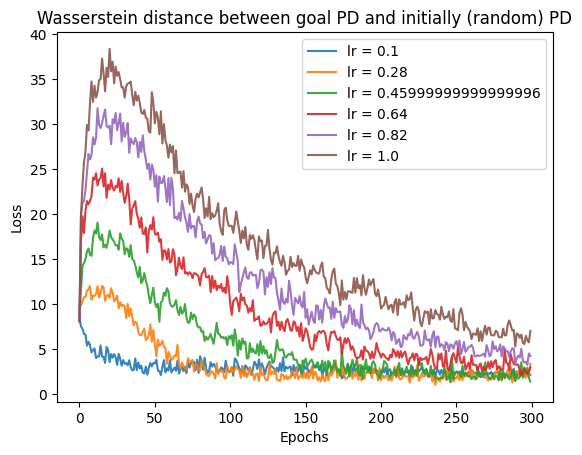

In [51]:
if sliced==False:
    plt.title("Wasserstein distance between goal PD and initially (random) PD")
elif isinstance(sliced, float):
    plt.title(f"Top-k=({sliced}) distance between goal PD and initially (random) PD")
elif sliced==True:
    plt.title("Sliced Wasserstein distance between goal PD and initially (random) PD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
for loss_list, lr in zip(loss_lists, lr_list):
    plt.plot(range(epochs), loss_list, label=f"lr = {lr}", alpha=0.9)
plt.legend(loc="upper right")
plt.show()

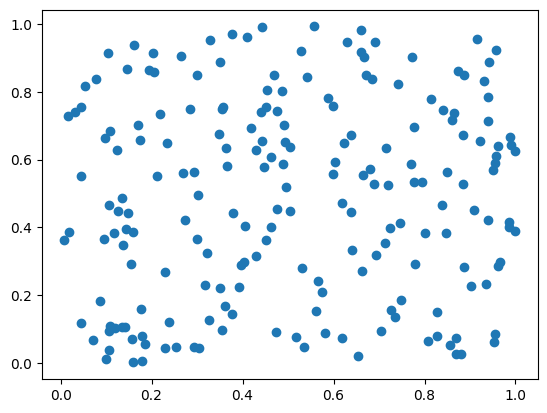

 16%|█▋        | 98/600 [00:02<00:09, 50.80it/s]

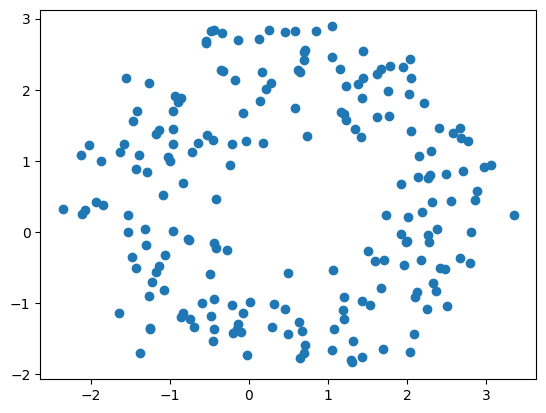

 33%|███▎      | 198/600 [00:04<00:08, 49.19it/s]

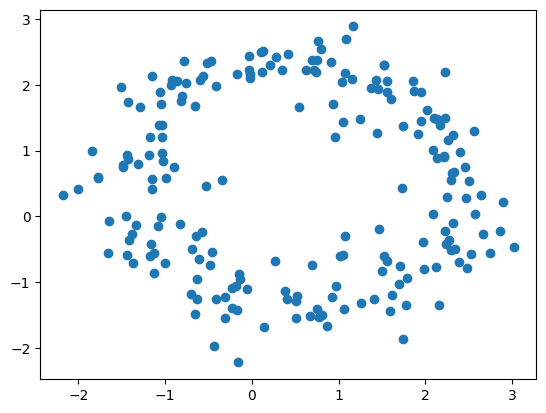

 50%|████▉     | 297/600 [00:06<00:05, 57.28it/s]

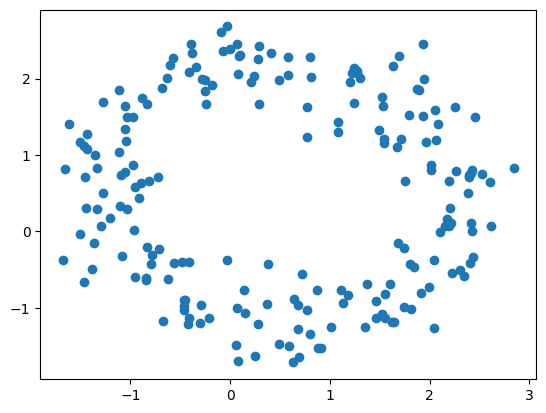

 66%|██████▌   | 397/600 [00:08<00:03, 54.25it/s]

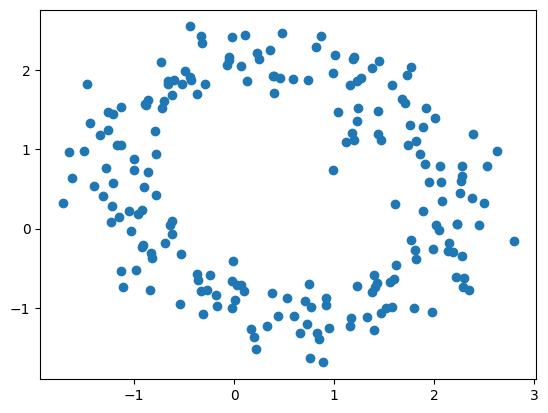

 83%|████████▎ | 498/600 [00:10<00:01, 58.59it/s]

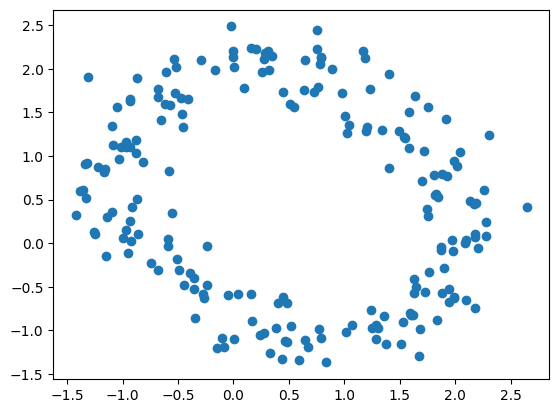

100%|█████████▉| 597/600 [00:12<00:00, 52.84it/s]

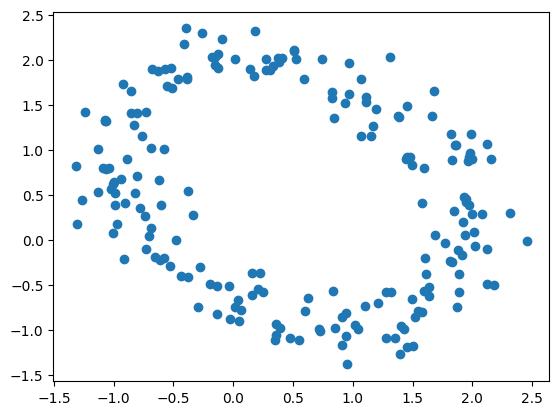

100%|██████████| 600/600 [00:12<00:00, 47.92it/s]


In [52]:
# Generation of new dataset
epochs = 600
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=dim, lr=0.45, epochs=epochs, decay_speed=decay_speed,\
                                    investigate=False, sliced=sliced, filtr=filtr)

### The powerspectrum

Later on we will focus on so-called Gaussian Random Fields (GRF). A characteristic feature of GRF's is their power spectrum. For that reason, we will already test whether the generated data set and the target dataset have the same power spectrum.

In [53]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [54]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

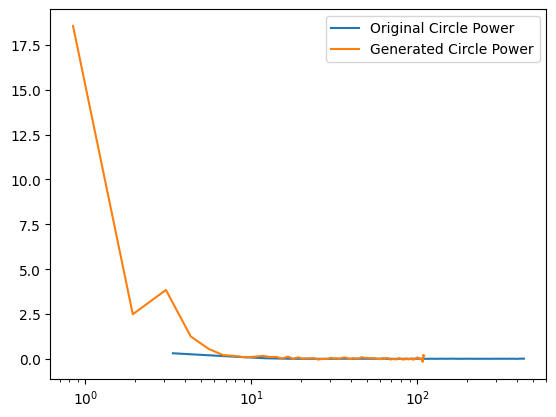

In [58]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
# plt.yscale('log')

## Alpha-Ripser Hybrid Filtration

### Creation of the new dataset

In [68]:
# Creation of the PD that we want to get to
goal_pd = pd.create_hybrid_pd(goal_pts)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

In [69]:
lr_list = np.linspace(0.1, 1, 6)

dim = 2
decay_speed = 30
sliced = False
epochs = 300
filtr = "alpha_rips_hybrid"
parallel = True
loss_lists = research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=dim, epochs=epochs, decay_speed=30, \
                                       sliced=sliced, filtr=filtr, box_size=box_size, parallel=parallel)

100%|██████████| 300/300 [00:14<00:00, 20.58it/s]


After running the above code, plug in the best learning rate:

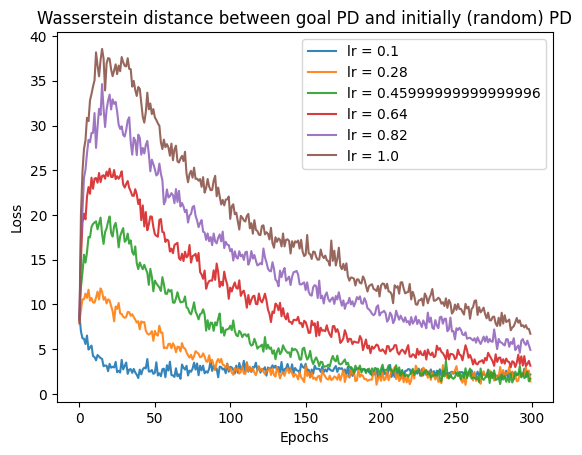

In [70]:
if sliced==False:
    plt.title("Wasserstein distance between goal PD and initially (random) PD")
elif isinstance(sliced, float):
    plt.title(f"Top-k=({sliced}) distance between goal PD and initially (random) PD")
elif sliced==True:
    plt.title("Sliced Wasserstein distance between goal PD and initially (random) PD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
for loss_list, lr in zip(loss_lists, lr_list):
    plt.plot(range(epochs), loss_list, label=f"lr = {lr}", alpha=0.9)
plt.legend(loc="upper right")
plt.show()

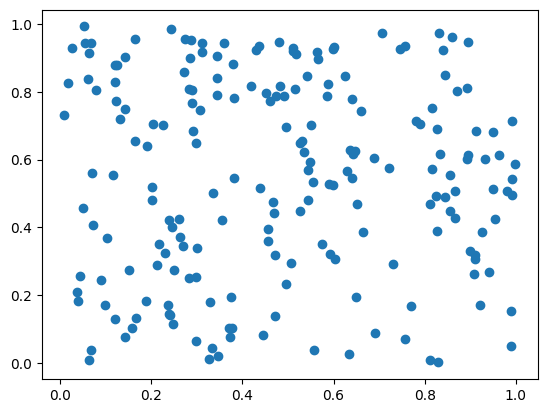

 16%|█▋        | 99/600 [00:02<00:16, 30.72it/s]

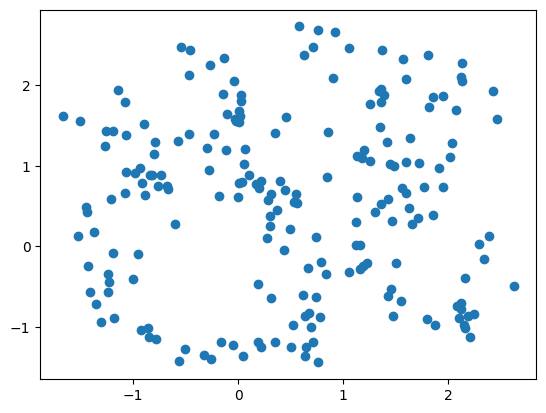

 32%|███▎      | 195/600 [00:05<00:08, 49.99it/s]

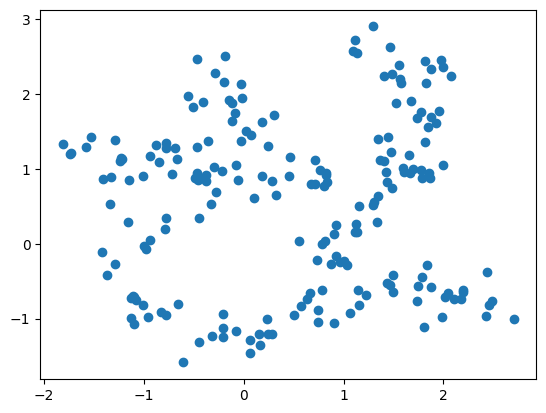

 50%|████▉     | 297/600 [00:07<00:05, 51.69it/s]

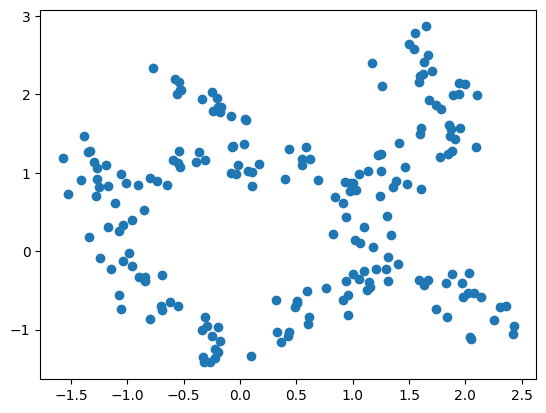

 66%|██████▌   | 395/600 [00:09<00:04, 46.18it/s]

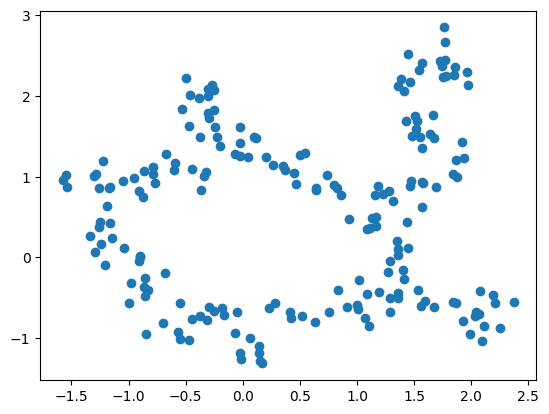

 83%|████████▎ | 497/600 [00:11<00:01, 62.90it/s]

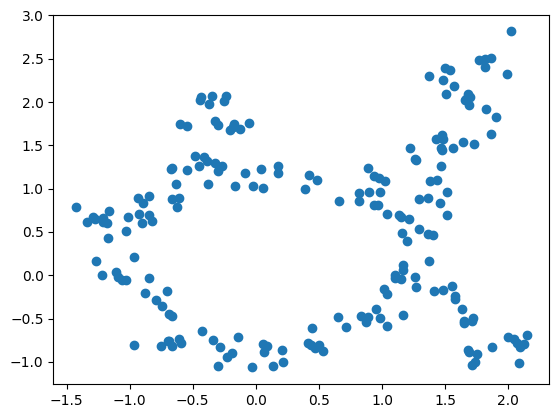

 99%|█████████▉| 594/600 [00:13<00:00, 50.33it/s]

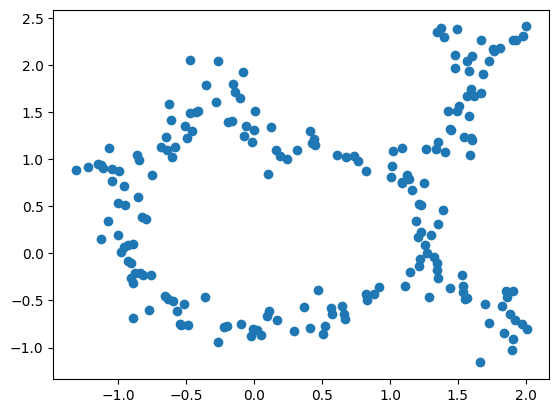

100%|██████████| 600/600 [00:13<00:00, 44.41it/s]


In [71]:
# Generation of new dataset
epochs = 600
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.28, epochs=epochs, decay_speed=decay_speed,\
                                    investigate=False, sliced=sliced, filtr=filtr)

### The powerspectrum

In [72]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [73]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

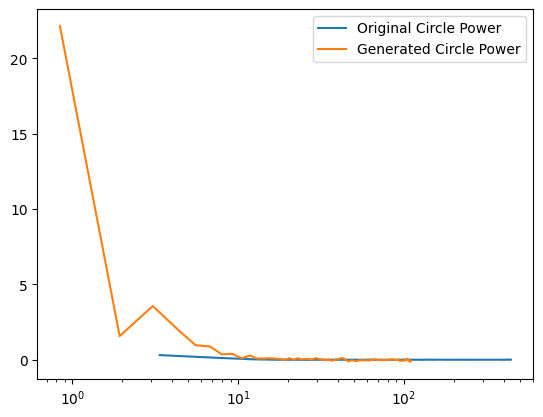

In [75]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
# plt.yscale('log')